# Project 3: Modeling a Car Jumping Over a Bridge


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian

<Unit('radian')>

In [3]:
params = Params(x = 0 * m, 
                y = 1 * m,
                l = 4.64 * m,
                w = 1.81 * m,
                h = 1.43 * m,
                g = 9.8 * m/s**2,
                mass = 1528.6 * kg,
                rho = 1.2 * kg/m**3,
                C_d = 0.29,
                angle = 45 * degree,
                velocity = 58 * m / s,
                t_end = 10 * s)

,values
x,0 meter
y,1 meter
l,4.64 meter
w,1.81 meter
h,1.43 meter
g,9.8 meter / second ** 2
mass,1528.6 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.29
angle,45 degree


In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = l * w
    
    return System(params, init=init, area=area)

In [5]:
system = make_system(params)

,values
x,0 meter
y,1 meter
l,4.64 meter
w,1.81 meter
h,1.43 meter
g,9.8 meter / second ** 2
mass,1528.6 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.29
angle,45 degree


In [6]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * v.mag**2 * C_d * area / 2
    direction = v.hat()
    f_drag = direction * mag
    return f_drag

In [7]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    v = Vector(vx, vy)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [8]:
slope_func(system.init, 0, system)

(<Quantity(41.01219330881976, 'meter / second')>,
 <Quantity(41.01219330881976, 'meter / second')>,
 <Quantity(-2.274012971897239, 'meter / second ** 2')>,
 <Quantity(-12.07401297189724, 'meter / second ** 2')>)

In [9]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

In [10]:
def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

In [19]:
height_func(80, params)

<Quantity(87.59953298448109, 'meter')>

In [31]:
def sweep_angle(angle_array, params):
    sweep = SweepSeries()
    
    for angle in angle_array:
        params = Params(params, angle=angle)
        system = make_system(params)
        sweep[angle] = height_func(angle, params)
        
    return sweep

,values
0,25.985437710168306 meter
5,66.85727673648341 meter
10,114.35195701322556 meter
15,158.1807891067269 meter
20,195.99070937541597 meter
25,226.93523444006314 meter
30,250.60103719683974 meter
35,266.78057212944725 meter
40,275.3970303832358 meter
45,276.46897860376066 meter


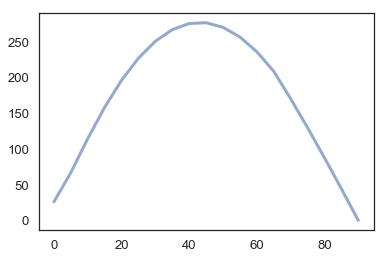

In [72]:
angle_array = linrange(0, 95, 5)
x_dist_array = sweep_angle(angle_array, params)
plot (x_dist_array)
res = max_bounded(height_func, [0,90], params)

In [116]:
def run_ode(angle, params):
    
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func, max_step = 0.2*s)
        
    return results

In [140]:
def sweep_angle_w_res():
    angle_array = linrange(20, 80, 10)
    from colour import Color
    purple = Color('purple')
    color_range = list(purple.range_to(Color('red'), len(angle_array)))

    for (angle, color) in zip(angle_array, color_range):
        res = run_ode(angle, params)
        x_dist = res.x
        y_dist = res.y
        plot (x_dist, y_dist, color=color.rgb, label="hi")

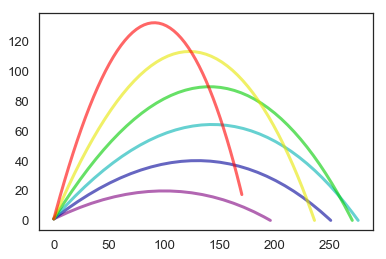

In [141]:
sweep_angle_w_res()

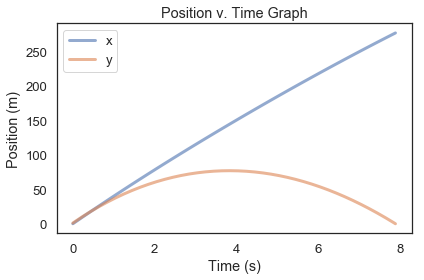

In [114]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step = 0.2*s)
plot(results.x, label='x')
plot(results.y, label='y')

decorate(title='Position v. Time Graph',
         xlabel='Time (s)',
         ylabel='Position (m)')

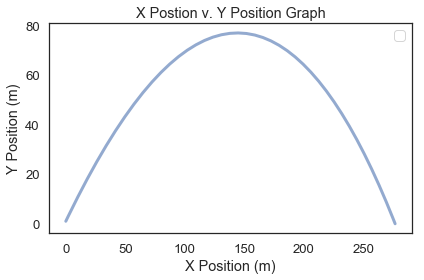

In [21]:
plot (results.x, results.y)

decorate(title='X Postion v. Y Position Graph',
         xlabel='X Position (m)',
         ylabel='Y Position (m)')

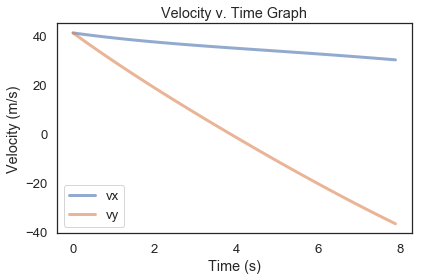

In [26]:
plot(results.vx, label='vx')
plot(results.vy, label='vy')

decorate(title='Velocity v. Time Graph',
         xlabel='Time (s)',
         ylabel='Velocity (m/s)')

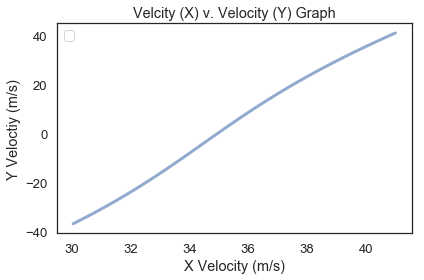

In [133]:
plot (results.vx, results.vy)

decorate(title='Velcity (X) v. Velocity (Y) Graph',
         xlabel='X Velocity (m/s)',
         ylabel='Y Veloctiy (m/s)')